<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_EBCM_markovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación usando EBCM markoviano.

Recordando las ecuaciones que lo definen.

$$\theta (t)=P(\text{ Test node u no ha recibido la infección al tiempo t } )$$
$$S(t)=\text{ Proporción de nodos susceptible = Probabilidad de que el test node sea susceptible}$$
$$S(t)+I(t)+R(t)=n$$
$$\psi =\text{ F.G.P de la distribución de grados.}$$
$$\beta,\gamma = \text{tasas de infección, recuperación.}$$


$$\dot{\theta}=-\beta \theta -\beta \frac{\psi'(\theta)}{\psi'(1)}-\gamma (1-\theta)$$
$$S(t)=\psi\left(\theta(t)\right)$$
$$I(t)=1-S(t)-R(t)$$
$$\dot{R}=\gamma I$$

## Mean Field Social Heterogeneity (MFSH)

$$\dot{\theta}=-\beta \theta +\beta \theta^2\frac{\psi'(\theta)}{\psi'(1)}-\gamma\theta log\left(\theta\right) $$
$$\dot{R}=\gamma\left(1-\psi(\theta)-R\right)$$
$$S=\psi(\theta)$$

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [50]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)#
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0 or t>T):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

## Ahora el EBCM

In [46]:
beta = 1.0
gamma = 1.0
I_0=0.01
def psi(x):
    return ((1/31)*(25*x+5*x**5+x**25))
def psi_prime(x):
    return (1/31)*(25+25*x**4+25*x**24)
from scipy.optimize import fsolve
def psi_CI(x):
  return psi(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
y0 = [theta_0, 0.0]
t = np.linspace(0, 10, 101)
def EBCM(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(1-theta), gamma*(1-psi(theta)-R)]
    return dydt
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
def EBCM_MFSH(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+(beta*theta**2)*(psi_prime(theta)/psi_prime(1))-gamma*(theta)*np.log(theta), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
sol = odeint(EBCM, y0, t, args=(beta, gamma,psi,psi_prime))
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,psi,psi_prime))
sol_MFSH = odeint(EBCM_MFSH, y0, t, args=(beta, gamma,psi,psi_prime))

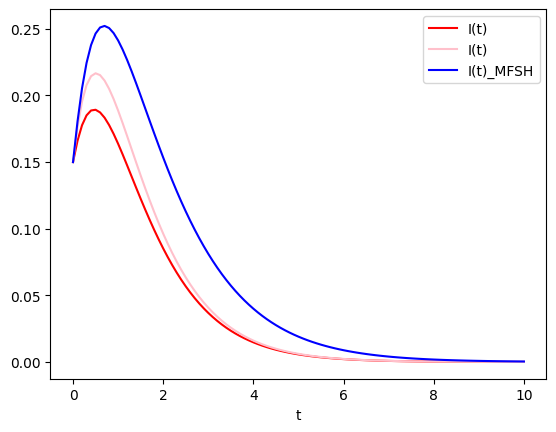

In [47]:
import matplotlib.pyplot as plt

plt.plot(t,1-psi(sol[:,0])-sol[:,1],'red',label='I(t)')
plt.plot(t,1-psi(sol_2[:,0])-sol_2[:,1],'pink',label='I(t)')
plt.plot(t,1-psi(sol_MFSH[:,0])-sol_MFSH[:,1],'blue',label='I(t)_MFSH')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

Comparación con simulación exacta.

In [43]:
import time
start_time = time.time()
N=10**4
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.choice(a=[1,5,25],size=N,p=[25/31,5/31,1/31])
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
#pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))

--- 49.850897550582886 Segundos para crear la gráfica ---


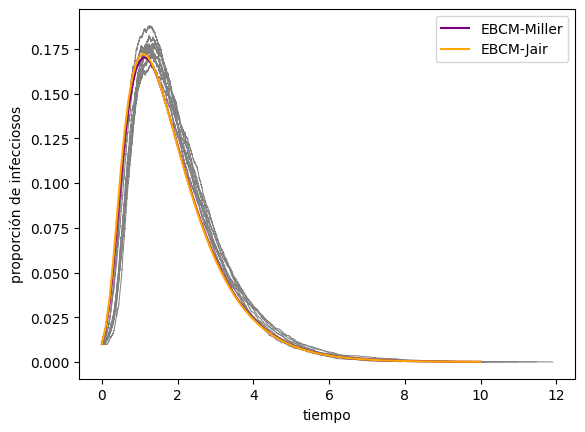

In [45]:
for iter in range(10):
    X_I_indexes=np.random.choice(range(1,N+1),size=int(I_0*N),replace=False)
    for k in range(N):
        if k in X_I_indexes:
            G.nodes[k]['Estado:']='Infeccioso'
        else:
            G.nodes[k]['Estado:']='Susceptible'
    iter_time = time.time()
    H=[]
    while(len(H)<10):
        G_copy=G.copy()
        X_I_indexes_copy=X_I_indexes.copy().tolist()
        H=Gillespie_Direct_Method_Network(beta=beta*N,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=10)
    plt.plot(H['time'],H['I(t)']/N,'gray',linewidth=0.7)
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-psi(sol[:,0])-sol[:,1],'purple',label='EBCM-Miller')
plt.plot(t,1-psi(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-Jair')
plt.legend()
plt.show()

### Otra
Pero sí espero que cambie si la condición inicial es muy grande.

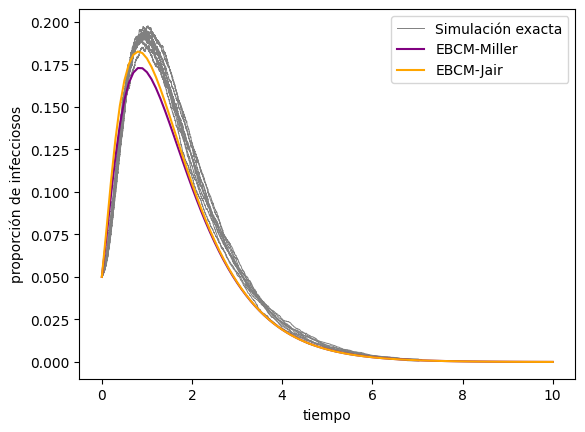

In [51]:
beta = 1.0
gamma = 1.0
I_0=0.05
def psi(x):
    return ((1/31)*(25*x+5*x**5+x**25))
def psi_prime(x):
    return (1/31)*(25+25*x**4+25*x**24)
from scipy.optimize import fsolve
def psi_CI(x):
  return psi(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
y0 = [theta_0, 0.0]
t = np.linspace(0, 10, 101)
def EBCM(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(1-theta), gamma*(1-psi(theta)-R)]
    return dydt
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
def EBCM_MFSH(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+(beta*theta**2)*(psi_prime(theta)/psi_prime(1))-gamma*(theta)*np.log(theta), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
sol = odeint(EBCM, y0, t, args=(beta, gamma,psi,psi_prime))
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,psi,psi_prime))
sol_MFSH = odeint(EBCM_MFSH, y0, t, args=(beta, gamma,psi,psi_prime))
for iter in range(10):
    X_I_indexes=np.random.choice(range(1,N+1),size=int(I_0*N),replace=False)
    for k in range(N):
        if k in X_I_indexes:
            G.nodes[k]['Estado:']='Infeccioso'
        else:
            G.nodes[k]['Estado:']='Susceptible'
    iter_time = time.time()
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy().tolist()
    H=Gillespie_Direct_Method_Network(beta=beta*N,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=7)
    if(iter==0):
      plt.plot(H['time'],H['I(t)']/N,'gray',linewidth=0.7,label='Simulación exacta')
    else:
      plt.plot(H['time'],H['I(t)']/N,'gray',linewidth=0.7)
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-psi(sol[:,0])-sol[:,1],'purple',label='EBCM-Miller')
plt.plot(t,1-psi(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-Jair')
plt.legend()
plt.show()

De rápido voy a intentar replicar las gráficas del articulo.

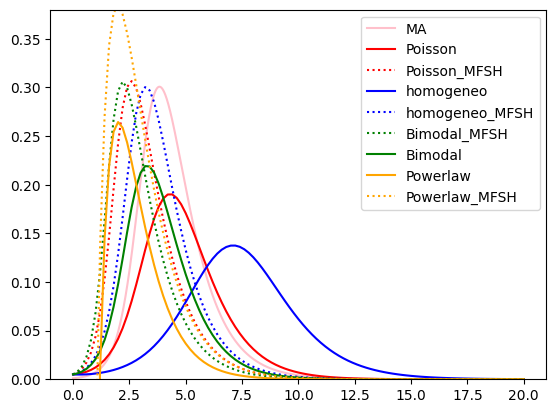

In [ ]:
beta=0.6
gamma=1.0
N=5*10**6
mean_k=5
## Caso MA: Ley de Acción de Masas.
from scipy.integrate import odeint
import scipy.integrate as spi
def ode_SIR(INP,t,ps): #Codigo hurtado del dropbox.
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL[:,1]

S0 = N-int(I_0*N)
I0 = int(I_0*N)
INPUT = (S0, I0, 0.0)
t_start = 0.0; t_end = 20; t_inc = .01
t_range = np.arange(t_start, t_end+t_inc, t_inc)
plt.plot(t_range,g(t_range,INPUT,[beta*(mean_k),gamma,N])/N, 'pink',label='MA')
#### Con simulación exacta:------------------------
#start_time=time.time()
#G=nx.fast_gnp_random_graph(N,p=1.0)#-------------------------------------------------
#print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
#graph_time = time.time()
#X_I_indexes=np.random.choice(N,size=I0,replace=False).tolist()
#for k in range(N):
#    if k in X_I_indexes:
#        G.nodes[k]['Estado:']='Infeccioso'
#    else:
#        G.nodes[k]['Estado:']='Susceptible'
#H=Gillespie_Direct_Method_Network(beta=beta*(mean_k),gamma=gamma,N=N,X_I_indexes=X_I_indexes,G_network_initial=G,T=np.inf)
#plt.plot(H['time'],H['I(t)']/N, 'b',linewidth=0.7,label='Simulación exacta')
#Caso Poisson
def psi_poisson(x):
    return np.exp(-mean_k*(1-x))
def psi_poisson_prime(x):
    return mean_k*np.exp(-mean_k*(1-x))
y0 = [1.0-I_0, 0.0]
t = np.linspace(0, 20, 101)
sol = odeint(EBCM, y0, t, args=(beta, gamma,psi_poisson,psi_poisson_prime))
sol_MFSH = odeint(EBCM_MFSH, y0, t, args=(beta, gamma,psi_poisson,psi_poisson_prime))

plt.plot(t,1-psi_poisson(sol[:,0])-sol[:,1],'red',label='Poisson')
plt.plot(t,1-psi_poisson(sol_MFSH[:,0])-sol_MFSH[:,1],':r',label='Poisson_MFSH')

#Caso homogeneo (regular).
def psi_regular(x):
    return x**mean_k
def psi_regular_prime(x):
    return mean_k*(x**(mean_k-1))
sol_reg= odeint(EBCM, y0, t, args=(beta, gamma,psi_regular,psi_regular_prime))
sol_reg_MFSH= odeint(EBCM_MFSH, y0, t, args=(beta, gamma,psi_regular,psi_regular_prime))
plt.plot(t,1-psi_regular(sol_reg[:,0])-sol_reg[:,1],'blue',label='homogeneo')
plt.plot(t,1-psi_regular(sol_reg_MFSH[:,0])-sol_reg_MFSH[:,1],':b',label='homogeneo_MFSH')

#Caso Bimodal.
def psi_bimodal(x):
    return ((1/2)*(x**2+x**8))
def psi_bimodal_prime(x):
    return (1/2)*(2*x+8*x**7)
sol_bim= odeint(EBCM, y0, t, args=(beta, gamma,psi_bimodal,psi_bimodal_prime))
sol_bim_MFSH= odeint(EBCM_MFSH, y0, t, args=(beta, gamma,psi_bimodal,psi_bimodal_prime))
plt.plot(t,1-psi_bimodal(sol_bim_MFSH[:,0])-sol_bim_MFSH[:,1],':g',label='Bimodal_MFSH')
plt.plot(t,1-psi_bimodal(sol_bim[:,0])-sol_bim[:,1],'green',label='Bimodal')

#Caso Powerlaw aproximado.
s=0
for k in range(1,10000):
    s+=k**(-1.418)*np.exp(-k/40)
s
def approx_psi_powerlaw(x):
    u=0
    for k in range(1,1000):
        u+=k**(-1.418)*np.exp(-k/40)*x**k
    return s*u
def approx_prime_psi_powerlaw(x):
    u=0
    for k in range(1,1000):
        u+=k**(-0.418)*np.exp(-k/40)*x**(k-1)
    return s*u
sol_pl= odeint(EBCM, y0, t, args=(beta, gamma,approx_psi_powerlaw,approx_prime_psi_powerlaw))
sol_pl_MFSH= odeint(EBCM_MFSH, y0, t, args=(beta, gamma,approx_psi_powerlaw,approx_prime_psi_powerlaw))
plt.plot(t,1-approx_psi_powerlaw(sol_pl[:,0])-sol_pl[:,1],'orange',label='Powerlaw')
plt.plot(t,1-approx_psi_powerlaw(sol_pl_MFSH[:,0])-sol_pl_MFSH[:,1],':',color='orange',label='Powerlaw_MFSH')
plt.ylim((0,0.38))
plt.legend()
plt.show()